Installing Dependencies

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Import

In [4]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

Folders

In [6]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [27]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [6]:
!tar -xf lfw.tgz

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

Video Capture

In [8]:
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\d6b1ec1d-e175-11ec-a55b-9c7bef1f52d6.jpg'

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    
    frame = frame[120:120+250,200:200+250, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        

cap.release()
cv2.destroyAllWindows()

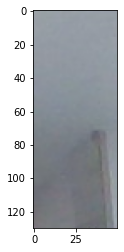

In [11]:
plt.imshow(frame[120:120+250,200:200+250, :])

Making directories for folders

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'data\\anchor\\78bb0a5f-e09f-11ec-9f2d-9c7bef1f52d6.jpg'


Image preprocessing

Data Augmentation

In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [16]:
def preprocess(file_path):
    
   
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [17]:
img = preprocess('data\\anchor\\1a1d5768-db40-11ec-b210-3cf0111818ab.jpg')

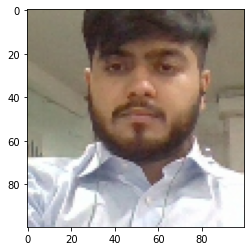

In [18]:
plt.imshow(img)

In [19]:
img.numpy().max() 

1.0

In [20]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

Create labelled dataset

In [21]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
#positives=1
#negatices=0

In [22]:
samples = data.as_numpy_iterator()

In [23]:
exampple = samples.next()

In [24]:
exampple


(b'data\\anchor\\957202c1-db3e-11ec-b9dd-3cf0111818ab.jpg',
 b'data\\positive\\5ce22fb4-e09f-11ec-adab-9c7bef1f52d6.jpg',
 1.0)

Preprocessing

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [26]:
res = preprocess_twin(*exampple)

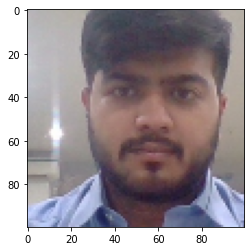

In [27]:
plt.imshow(res[1])

In [28]:
res[2]

1.0

In [29]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [30]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [31]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Embedding layer

In [32]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [33]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [34]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [35]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [36]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [37]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [38]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [39]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [40]:
class L1Dist(Layer):
    
   #inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    #similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [41]:
l1 = L1Dist()


In [42]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

Model

In [43]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [44]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)


In [45]:
siamese_layer = L1Dist()

In [46]:
distances = siamese_layer(inp_embedding, val_embedding)

In [47]:
classifier = Dense(1, activation='sigmoid')(distances)

In [48]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [50]:
siamese_model = make_siamese_model()

Training

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [53]:
#checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
batch_1 = test_batch.next()

In [56]:
X = batch_1[:2]

In [57]:
y = batch_1[2]

In [58]:
y

array([1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

In [59]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export('keras.losses.BinaryCrossentropy')
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss for binary (0 or 1) classification applications.
  The loss function requires the following inputs:

  - `y_true` (true label): This is either 0 or 1.
  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
    floating-point value which either represents a
    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
    `from_logits=False`).

  **Recommended Usage:** (set `from_logits=True`)

  With `tf.keras` API:

  ```python
  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_log

In [60]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
       
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    
    return loss


In [61]:
from tensorflow.keras.metrics import Precision, Recall

In [62]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        #save
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [63]:
EPOCHS = 50

In [64]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 33s 14s/step
0.67612803 0.2 1.0

 Epoch 2/50
2/2 [==============================] - 32s 13s/step
0.5088291 0.15384616 1.0

 Epoch 3/50
2/2 [==============================] - 31s 13s/step
0.47632495 0.14285715 1.0

 Epoch 4/50
2/2 [==============================] - 31s 13s/step
0.6099639 0.14285715 1.0

 Epoch 5/50
2/2 [==============================] - 31s 13s/step
0.47454593 0.071428575 1.0

 Epoch 6/50
2/2 [==============================] - 31s 13s/step
0.52329594 0.35714287 1.0

 Epoch 7/50
2/2 [==============================] - 33s 14s/step
0.41222346 0.5 1.0

 Epoch 8/50
2/2 [==============================] - 33s 13s/step
0.29772902 0.8 1.0

 Epoch 9/50
2/2 [==============================] - 32s 13s/step
0.4271116 0.8181818 1.0

 Epoch 10/50
2/2 [==============================] 

Metrics

In [65]:
from tensorflow.keras.metrics import Precision, Recall

In [66]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [67]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [68]:
[1 if prediction > 0.7 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]

In [69]:
y_true

array([1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.], dtype=float32)

Calculate Recall

In [126]:
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

0.2

In [127]:
m = Precision()


m.update_state(y_true, y_hat)

m.result().numpy()
1.0

1.0

In [128]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)   

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 1s/step
1.0 1.0


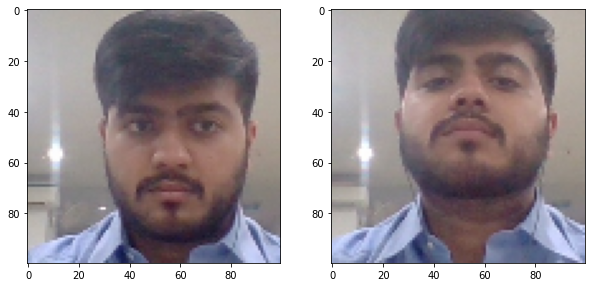

In [129]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()


In [130]:
siamese_model.save('siamesemodelv2.h5')

In [131]:
L1Dist

__main__.L1Dist

In [132]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [133]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

application_data\verification_images

In [134]:
os.listdir(os.path.join('application_data', 'verification_images'))

['26a7a8f6-db42-11ec-bcf9-3cf0111818ab.jpg',
 '2745fb78-db42-11ec-b136-3cf0111818ab.jpg',
 '4b2d2c9a-e09f-11ec-848c-9c7bef1f52d6.jpg',
 '4b9c8b9f-e09f-11ec-be47-9c7bef1f52d6.jpg',
 '4bb7738d-e09f-11ec-a480-9c7bef1f52d6.jpg',
 '4befa1ec-e09f-11ec-9bd2-9c7bef1f52d6.jpg',
 '52734ccc-e09f-11ec-ac4c-9c7bef1f52d6.jpg',
 '5393f856-e09f-11ec-bcc1-9c7bef1f52d6.jpg',
 '555a9361-e09f-11ec-8c71-9c7bef1f52d6.jpg',
 '59719e73-e09f-11ec-a08e-9c7bef1f52d6.jpg',
 '5af5bf74-e09f-11ec-8f18-9c7bef1f52d6.jpg',
 '5b0e1d6c-e09f-11ec-ba3b-9c7bef1f52d6.jpg',
 '5bd8592f-e09f-11ec-8041-9c7bef1f52d6.jpg',
 '5c17a033-e09f-11ec-98a6-9c7bef1f52d6.jpg',
 '5c5dbaf0-e09f-11ec-83cf-9c7bef1f52d6.jpg',
 '5ce22fb4-e09f-11ec-adab-9c7bef1f52d6.jpg',
 '5f4d803c-e09f-11ec-a7b6-9c7bef1f52d6.jpg',
 '619bd563-e09f-11ec-b933-9c7bef1f52d6.jpg',
 '629b5fbc-e09f-11ec-bccf-9c7bef1f52d6.jpg',
 '62d7c8bb-e09f-11ec-a4d8-9c7bef1f52d6.jpg',
 '650c11c2-e09f-11ec-a017-9c7bef1f52d6.jpg',
 '6534b55f-e09f-11ec-9f70-9c7bef1f52d6.jpg',
 '679400f0

In [135]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [136]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\26a7a8f6-db42-11ec-bcf9-3cf0111818ab.jpg
application_data\verification_images\2745fb78-db42-11ec-b136-3cf0111818ab.jpg
application_data\verification_images\4b2d2c9a-e09f-11ec-848c-9c7bef1f52d6.jpg
application_data\verification_images\4b9c8b9f-e09f-11ec-be47-9c7bef1f52d6.jpg
application_data\verification_images\4bb7738d-e09f-11ec-a480-9c7bef1f52d6.jpg
application_data\verification_images\4befa1ec-e09f-11ec-9bd2-9c7bef1f52d6.jpg
application_data\verification_images\52734ccc-e09f-11ec-ac4c-9c7bef1f52d6.jpg
application_data\verification_images\5393f856-e09f-11ec-bcc1-9c7bef1f52d6.jpg
application_data\verification_images\555a9361-e09f-11ec-8c71-9c7bef1f52d6.jpg
application_data\verification_images\59719e73-e09f-11ec-a08e-9c7bef1f52d6.jpg
application_data\verification_images\5af5bf74-e09f-11ec-8f18-9c7bef1f52d6.jpg
application_data\verification_images\5b0e1d6c-e09f-11ec-ba3b-9c7bef1f52d6.jpg
application_data\verification_images\5bd8592f-e09f-11ec-8041-9c7

In [137]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [143]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
       

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        results, verified = verify(siamese_model, 0.6, 0.6)
        print(verified)
    
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 244ms/step
True
1/1 [==============================] - 0s 216ms/step
False


In [139]:
np.sum(np.squeeze(results) > 0.9)

0

In [140]:
results

[array([[0.0144536]], dtype=float32),
 array([[0.01306615]], dtype=float32),
 array([[0.00198152]], dtype=float32),
 array([[0.00506742]], dtype=float32),
 array([[0.00263445]], dtype=float32),
 array([[0.00215038]], dtype=float32),
 array([[0.00050604]], dtype=float32),
 array([[0.00087949]], dtype=float32),
 array([[0.00033228]], dtype=float32),
 array([[0.00097886]], dtype=float32),
 array([[0.00085453]], dtype=float32),
 array([[0.00011171]], dtype=float32),
 array([[0.0001685]], dtype=float32),
 array([[0.0004053]], dtype=float32),
 array([[0.00019915]], dtype=float32),
 array([[0.00043897]], dtype=float32),
 array([[0.00018478]], dtype=float32),
 array([[0.15929006]], dtype=float32),
 array([[0.08807345]], dtype=float32),
 array([[0.14188516]], dtype=float32),
 array([[0.00176473]], dtype=float32),
 array([[0.00319024]], dtype=float32),
 array([[0.00115879]], dtype=float32),
 array([[0.00151236]], dtype=float32)]